## Common parts

### Imports
Ensure all libraries are installed /w "requirements.txt"

In [1]:
# Common libs
import numpy as np
import time
import pandas as pd
import skfuzzy as fuzz
from IPython.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

In [2]:
# Self-made functions
import sm_libs.data_loading as dl
import sm_libs.knn_core as knnc

### Re-usable Functions

In [3]:
def run_knn(np_file_data, col_masks, np_compare_data, k = 10):

    # ---------------- Run C++-Accelerated k-NN ----------------
    neighbors_per_file = []

    for i in range(len(np_file_data)):
        print(f"Processing file {i} using C++ module...", flush=True)

        neighbors = knnc.knn_for_file(
            np_file_data[i],   # NumPy 2D array for file i
            i,                 # Index of current file
            np_compare_data,      # List of all NumPy arrays
            col_masks,      # List of lists of global attribute indices
            k,
            len(all_attrs)     # Total number of global attributes
        )

        neighbors_per_file.append(neighbors)

    print(f"C++ k-NN completed.")
    return neighbors_per_file

In [4]:
def impute(np_neighbors):
    # ---------------- Data postprocessing ----------------
    imputed_file_data_list = []

    for f_idx, f_rows in enumerate(file_data):
        imputed_rows = []
        neighbors_per_row = np_neighbors[f_idx]

        for r_idx, r in enumerate(f_rows):
            row_dict = r.copy()
            neighbors = neighbors_per_row[r_idx]

            missing_attrs = [attr for attr in all_attrs if attr not in row_dict]

            for missing_attr in missing_attrs:
                values = []

                for dist, n_file_idx, n_row_idx in neighbors:
                    neighbor_row = file_data[n_file_idx][n_row_idx]
                    if missing_attr in neighbor_row:
                        values.append(neighbor_row[missing_attr])

                if values:
                    imputed_value = np.mean(values)
                    row_dict[missing_attr] = imputed_value
                else:
                    # Leave missing if no neighbor has the value
                    row_dict[missing_attr] = np.nan

            imputed_rows.append(row_dict)

        imputed_file_data_list.append(imputed_rows)

    return imputed_file_data_list

In [5]:
def print_table(imputed_list):
    for f_idx, f_rows in enumerate(imputed_list):
        df = pd.DataFrame(f_rows)

        # Sort columns numerically if possible
        sorted_cols = sorted(
            df.columns,
            key=lambda x: int(x) if str(x).isdigit() else float("inf")
        )

        df_result = df[sorted_cols]  # Reorder columns

        # Display with heading
        display(HTML(f"<h4>File {f_idx} – {len(df_result)} rows</h4>"))
        display(df_result.reset_index(drop=True))  # Remove left index

In [6]:
def calculate_fcm_clusters(np_file_data, n_clusters=2, m=2.0, error=0.005, maxiter=100):
    """
    Calculate fuzzy c-means cluster centers for each file's data.
    Returns list of numpy arrays with cluster centers per file.
    """
    cluster_centers_list = []
    for i, data in enumerate(np_file_data):
        if data.shape[0] < n_clusters:
            # Not enough data points for requested clusters — just use the data as centers
            cluster_centers_list.append(data)
            continue

        # Transpose data to shape (features, samples) for skfuzzy
        data_T = data.T

        # Run fuzzy c-means
        cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            data_T, c=n_clusters, m=m, error=error, maxiter=maxiter, init=None
        )
        # cntr shape = (n_clusters, n_features)
        cluster_centers_list.append(cntr)
    return cluster_centers_list

In [7]:
def get_statistics(imputed_pureKNN, imputed_fcmKNN):
    vals_pureKNN = []
    vals_fcmKNN = []

    # Initialize dicts to count NaNs per attr
    nan_counts_per_attr_pureKNN = {attr: 0 for attr in all_attrs}
    nan_counts_per_attr_fcmKNN = {attr: 0 for attr in all_attrs}

    for attr in all_attrs:
        for file_i in range(10):
            num_r = len(imputed_pureKNN[file_i])
            for row_i in range(num_r):
                v1 = imputed_pureKNN[file_i][row_i].get(attr, np.nan)
                v2 = imputed_fcmKNN[file_i][row_i].get(attr, np.nan)

                vals_pureKNN.append(v1)
                vals_fcmKNN.append(v2)

                # Count NaNs globally
                if v1 is np.nan or (v1 != v1):
                    nan_counts_per_attr_pureKNN[attr] += 1
                if v2 is np.nan or (v2 != v2):
                    nan_counts_per_attr_fcmKNN[attr] += 1

    np_pureKNN = np.array(vals_pureKNN, dtype=np.float64)
    np_fcmKNN = np.array(vals_fcmKNN, dtype=np.float64)

    mask = ~np.isnan(np_pureKNN) & ~np.isnan(np_fcmKNN)
    np_pureKNN_clean = np_pureKNN[mask]
    np_fcmKNN_clean = np_fcmKNN[mask]

    return np_pureKNN_clean, np_fcmKNN_clean, nan_counts_per_attr_pureKNN, nan_counts_per_attr_fcmKNN

In [8]:
def mean_values(arr_pureKNN_clean, arr_fcmKNN_clean):
    mae_ = mean_absolute_error(arr_pureKNN_clean, arr_fcmKNN_clean)
    mse_ = mean_squared_error(arr_pureKNN_clean, arr_fcmKNN_clean)

    # Sanity check: Pearson correlation
    corr_, p_value_ = pearsonr(arr_pureKNN_clean, arr_fcmKNN_clean)
    return mae_, mse_, corr_, p_value_

In [9]:
def plot_results(_iterations, _nr_clusters, _durations, _mses):
    # Plotting Duration Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(_durations, xticklabels=_nr_clusters, yticklabels=_iterations, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title("Duration Heatmap (seconds)")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Iterations")
    plt.show()

    # Plotting MSE Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(_mses, xticklabels=_nr_clusters, yticklabels=_iterations, annot=True, fmt=".4f", cmap="Reds")
    plt.title("Mean Squared Error (MSE) Heatmap")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Iterations")
    plt.show()

    # Plot MSE vs Number of Clusters for different iterations
    plt.figure(figsize=(10, 6))
    for i, it in enumerate(_iterations):
        plt.plot(_nr_clusters, _mses[i, :], marker='o', label=f'{it} Iterations')
    plt.title("MSE vs Number of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Duration vs Number of Clusters for different iterations
    plt.figure(figsize=(10, 6))
    for i, it in enumerate(_iterations):
        plt.plot(_nr_clusters, _durations[i, :], marker='o', label=f'{it} Iterations')
    plt.title("Duration vs Number of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Duration (seconds)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Data Loading

In [10]:
# ---------------- Configuration ----------------
data_type = 'duze'
data_ver = 1
full_base_path = f'../dane/{data_type}/{data_ver}'

print(f"Loading data from: {full_base_path}")
file_data, all_attrs = dl.load_files(full_base_path, data_type)
all_attrs = sorted([str(attr) for attr in all_attrs])  # Ensure string consistency

print(f"Loaded {len(file_data)} files")
for i, file_rows in enumerate(file_data):
    print(f"  File {i}: {len(file_rows)} rows")
print(f"Total attributes: {len(all_attrs)}")

Loading data from: ../dane/duze/1
Loaded 10 files
  File 0: 7888 rows
  File 1: 7816 rows
  File 2: 6463 rows
  File 3: 5128 rows
  File 4: 5423 rows
  File 5: 6594 rows
  File 6: 6044 rows
  File 7: 6700 rows
  File 8: 7552 rows
  File 9: 6281 rows
Total attributes: 17


### Data Preprocessing

In [11]:
# ---------------- Prepare Data for C++ ----------------

# Map: attribute name → index
attr_to_index = {attr: idx for idx, attr in enumerate(all_attrs)}

# Convert file rows (list of dicts) → numpy arrays with shared attr ordering
np_common_file_data = []
column_masks = []

for file_rows in file_data:
    # Find present attributes in this file
    present_attrs = [attr for attr in all_attrs if attr in file_rows[0]]
    column_masks.append([attr_to_index[attr] for attr in present_attrs])

    # Create numpy array for this file
    rows = []
    for row in file_rows:
        row_values = [row[attr] for attr in present_attrs]
        rows.append(row_values)

    np_array = np.array(rows, dtype=np.float64)
    np_common_file_data.append(np_array)

# Pure KNN

In [12]:
# Deep copy numpy arrays inside the list
np_pureKNN_file_data = [arr.copy() for arr in np_common_file_data]

In [13]:
# ---------------- Calculate k-NN ----------------
print("Calculating k-NN...")

pureKNN_KNN_duration = time.time()
np_pureKNN_neighbors = run_knn(np_pureKNN_file_data, column_masks, np_pureKNN_file_data)
pureKNN_KNN_duration = time.time() - pureKNN_KNN_duration

print(f"Calculating k-NN took: {pureKNN_KNN_duration:.2f} seconds.")

Calculating k-NN...
Processing file 0 using C++ module...
Processing file 1 using C++ module...
Processing file 2 using C++ module...
Processing file 3 using C++ module...
Processing file 4 using C++ module...
Processing file 5 using C++ module...
Processing file 6 using C++ module...
Processing file 7 using C++ module...
Processing file 8 using C++ module...
Processing file 9 using C++ module...
C++ k-NN completed.
Calculating k-NN took: 155.07 seconds.


In [14]:
# ---------------- Impute data ----------------
print("Imputing data...")

pureKNN_imputation_duration = time.time()
pureKNN_imputed = impute(np_pureKNN_neighbors)
pureKNN_imputation_duration = time.time() - pureKNN_imputation_duration

print("\nImputed data preview for the first file:")

preview_rows = pureKNN_imputed[1][:10]
print(preview_rows)

print(f"Imputation took: {pureKNN_imputation_duration:.2f} seconds.")

Imputing data...

Imputed data preview for the first file:
[{'0': 4.84038, '3': 3.02869, '4': 0.239666, '6': 0.0488068, '7': 0.00299133, '8': 2.09979, '9': 40.317, '10': 3.0525, '11': 0.459937, '12': 172.664, '14': 4.02054, '15': 2.62657, '1': nan, '13': 140.7594, '16': 1.901851, '2': 8.90317, '5': 6.9854189999999985}, {'0': 11.4375, '3': 3.16232, '4': 0.352491, '6': 0.0493689, '7': 0.00292049, '8': 2.05713, '9': 40.4432, '10': 3.1351, '11': 6.46077, '12': 189.453, '14': 6.89141, '15': 2.55419, '1': 0.9595373333333334, '13': 142.3236, '16': 0.8936643999999999, '2': 4.926035714285716, '5': 3.015109}, {'0': 3.43328, '3': 8.30775, '4': 0.901191, '6': 0.0298853, '7': 0.0100217, '8': 3.04757, '9': 41.8146, '10': 4.06459, '11': 7.25826, '12': 216.431, '14': 9.42478, '15': 4.41587, '1': nan, '13': 168.3818, '16': 2.732917, '2': 2.482863, '5': 6.018627}, {'0': 3.47715, '3': 3.3805, '4': 2.43171, '6': 1.06505, '7': 0.00609244, '8': 2.69146, '9': 47.8504, '10': 4.03641, '11': 7.0258, '12': 240.3

In [15]:
print_table(pureKNN_imputed)

pureKNN_total_duration = pureKNN_KNN_duration + pureKNN_imputation_duration
print(f"Total pure k-NN took: { pureKNN_total_duration:.2f} seconds.")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.350733,1.666010,2.51232,8.39050,1.150690,5.967370,0.029354,0.009957,2.84841,41.5645,3.89550,6.77960,233.522800,161.440,9.415430,4.520283,2.384190
1,3.949583,1.078350,9.25038,3.02807,0.237986,7.044580,0.051256,0.002860,1.99231,38.9407,2.96491,1.15217,196.632778,141.780,3.998770,2.512146,1.901350
2,4.148410,1.021660,8.72897,2.99291,0.090507,7.088165,0.049396,0.002914,1.59997,42.7964,2.93290,2.51005,195.443714,148.369,3.928700,2.505157,1.896810
3,4.102430,1.274130,1.47564,2.11190,0.349528,5.352164,0.027533,0.006040,4.90712,42.4476,4.20593,4.59337,232.440222,164.434,5.496760,3.495385,0.340892
4,2.944202,2.152350,7.90424,6.39727,0.844579,0.960187,0.200882,0.005044,3.08559,40.8261,2.93797,5.66530,203.179667,130.984,1.011610,6.495937,1.518340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7883,3.458237,1.454230,5.90067,3.40713,2.127260,5.374915,1.070420,0.005998,2.51874,44.1582,4.09365,7.08064,239.714375,171.871,12.132900,3.487239,1.754800
7884,3.051906,2.325780,7.39412,6.31952,0.741474,0.997165,0.199752,0.004929,2.60434,40.5748,2.93340,4.75360,197.880667,139.428,0.959101,6.486822,1.486350
7885,3.847157,0.981022,8.83619,2.93794,0.213116,7.007011,0.050851,0.003082,2.09385,40.9310,2.99524,4.60853,198.460444,129.341,4.079300,2.452838,1.900810
7886,3.970354,1.102750,8.79556,3.09835,0.276393,6.944388,0.051007,0.002897,2.28175,38.7168,2.91616,1.49868,206.229222,142.251,4.026210,2.483969,1.903180


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,4.84038,NaN,8.903170,3.02869,0.239666,6.985419,0.048807,0.002991,2.09979,40.3170,3.05250,0.459937,172.664,140.7594,4.02054,2.62657,1.901851
1,11.43750,0.959537,4.926036,3.16232,0.352491,3.015109,0.049369,0.002920,2.05713,40.4432,3.13510,6.460770,189.453,142.3236,6.89141,2.55419,0.893664
2,3.43328,NaN,2.482863,8.30775,0.901191,6.018627,0.029885,0.010022,3.04757,41.8146,4.06459,7.258260,216.431,168.3818,9.42478,4.41587,2.732917
3,3.47715,1.782840,5.577619,3.38050,2.431710,5.272646,1.065050,0.006092,2.69146,47.8504,4.03641,7.025800,240.365,172.5966,11.97370,3.54874,1.851904
4,3.42431,2.063160,2.460147,8.50721,0.879097,6.051320,0.032368,0.009518,2.87997,43.5889,3.94057,6.308240,216.764,161.3912,9.51658,4.51532,2.653509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7811,4.20150,1.638225,1.343834,2.44864,0.306999,5.239336,0.029513,0.006099,4.44764,41.7354,4.20508,6.294550,219.735,166.5134,5.58153,3.44768,0.371507
7812,3.70578,1.653900,2.550432,8.28953,0.908873,5.993961,0.031028,0.009776,2.34107,41.6429,4.24417,6.185730,217.967,163.8165,9.51779,4.60432,2.830692
7813,3.54130,NaN,5.505240,3.34258,2.180420,5.375332,1.068430,0.005788,2.76204,46.3045,3.90576,7.816170,241.260,170.5580,12.08720,3.49095,1.838427
7814,11.21760,1.195560,5.082162,3.01607,0.191839,3.012625,0.048875,0.002972,1.85773,41.0488,3.02337,5.909210,213.979,139.4192,6.80187,2.53873,0.900894


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.65638,1.62526,5.502621,3.434428,2.291000,5.35967,1.067320,0.006105,2.86673,47.9436,4.17616,6.046209,241.665889,180.939,11.941750,3.54530,1.942190
1,3.60863,2.35243,2.377900,8.370886,0.880133,5.98546,0.031086,0.010065,2.83787,41.5331,4.11255,6.005364,226.186333,171.762,9.522853,4.50500,2.816370
2,6.38161,2.08846,5.390865,3.472935,1.221670,2.77419,0.032261,0.003312,2.30100,46.7149,4.15993,5.833600,223.916400,160.503,5.098068,1.28930,1.478090
3,3.14040,2.18666,6.828466,6.390313,0.853424,1.11480,0.200121,0.006037,2.73821,40.3760,2.86566,4.900037,201.793000,143.182,1.850937,6.75011,1.501230
4,4.02849,1.51106,1.552873,2.367150,0.180420,5.58368,0.024962,0.005940,5.05512,42.9976,4.00919,5.658944,229.940700,158.393,5.484909,3.60090,0.140132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6458,3.51409,1.44504,5.664833,3.400150,2.246800,5.30942,1.072730,0.005900,2.76917,47.5201,4.19158,6.554949,240.656400,163.295,11.993490,3.42219,1.432450
6459,11.36030,1.01429,5.038742,2.987493,0.305842,3.00218,0.050228,0.003103,2.23612,41.3004,2.92388,5.278449,200.564571,143.442,7.040605,2.37636,0.910025
6460,11.07150,1.16439,4.974743,2.910047,0.220503,2.97578,0.050205,0.003037,1.74902,40.7207,2.93546,4.820876,204.285778,139.555,6.998616,2.52775,0.911762
6461,3.02615,2.05107,7.407046,6.430345,0.719424,1.01861,0.201262,0.004894,2.50123,40.3359,2.99895,4.079285,202.857200,140.109,0.955145,6.56380,1.499520


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.03790,2.323400,7.578960,6.20434,0.855720,0.869235,0.199064,0.005102,2.96946,39.404925,3.018782,3.26735,209.756,144.165,1.05061,6.51786,1.503656
1,11.47200,0.895736,4.955954,2.93808,0.244758,3.035920,0.049836,0.003094,2.14365,39.814300,3.005811,3.36612,189.428,139.359,7.15199,2.46287,0.896999
2,6.35181,2.192280,5.503566,3.36528,1.142665,2.750340,0.028982,0.003513,2.70049,47.880729,4.062510,6.08422,224.348,168.289,5.14128,1.40966,1.607558
3,3.43956,1.203620,5.554673,3.41218,2.278447,5.335140,1.074210,0.006012,2.97982,47.066600,4.021953,7.66572,235.220,175.814,12.01630,3.39295,1.831610
4,10.64230,1.085860,5.057564,3.11557,0.205300,3.107080,0.050811,0.002726,1.93297,40.028600,2.992181,4.75881,200.516,142.358,7.05904,2.46659,0.895720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5123,3.10193,2.061130,7.606481,6.36216,0.748276,0.829424,0.199626,0.005080,2.67539,40.325660,2.945570,3.46325,204.437,134.566,1.06842,6.50465,1.499198
5124,11.35340,1.037520,5.065117,3.07818,0.201644,2.997160,0.049894,0.002946,1.95289,39.252183,3.001498,4.41257,195.653,132.888,7.07044,2.40770,0.893342
5125,5.68506,1.674510,7.622565,3.46573,0.759764,3.135640,NaN,0.003095,3.32968,64.790571,1.086402,6.30486,230.562,172.438,7.63911,8.80769,3.715615
5126,4.14921,1.098290,9.008452,2.79139,0.192209,6.946020,0.048483,0.003107,2.13743,40.107380,2.989903,3.91194,209.475,138.053,4.01370,2.71520,1.900118


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2.96026,2.382510,7.41876,6.46672,0.810666,1.006591,0.200943,0.005087,2.70730,39.70992,2.952461,5.24460,196.613800,130.801,0.945804,6.482201,NaN
1,3.95920,1.132020,9.06645,2.78885,0.157862,7.004148,0.049643,0.002879,2.08401,39.56277,3.018588,2.91816,195.314900,150.009,3.986540,2.495713,1.881170
2,5.45844,2.032300,7.62362,3.29945,0.899747,3.074142,0.499579,0.002932,2.89723,65.02379,1.094547,6.09290,226.168889,164.021,7.617220,8.472432,3.766265
3,6.56254,1.956320,6.24615,3.61676,1.277880,2.925909,0.030787,0.002368,2.75136,47.88568,4.055453,5.14217,227.887400,157.448,4.979490,1.315292,NaN
4,4.07447,1.445800,1.58737,2.23133,0.320011,5.293728,0.031067,0.006062,4.97865,41.55661,4.101133,4.79222,224.277222,160.448,5.483780,3.510464,0.514048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5418,10.92190,0.821039,4.73318,2.74420,0.130111,2.994963,NaN,0.002903,2.16829,39.92619,2.962814,5.65048,198.380700,139.376,7.047210,2.522464,NaN
5419,6.50032,2.080400,5.25999,3.46980,1.126800,2.869096,0.030891,0.002742,2.47739,46.97467,4.119842,6.14403,220.901889,158.070,5.170340,1.325376,1.613980
5420,2.94860,2.215950,7.35850,6.22890,0.947651,1.039221,0.200548,0.004633,2.87398,39.75679,3.006204,4.44691,202.372500,134.061,1.039390,6.496060,NaN
5421,4.14399,1.667320,1.12851,2.34107,0.402125,5.325585,NaN,0.006116,4.36704,41.84290,4.087857,7.17780,229.337500,163.138,5.515310,3.496955,NaN


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.504540,NaN,2.66345,8.14937,1.039900,5.902140,0.030053,0.010071,2.52334,39.3584,4.09065,5.29308,219.530,165.706333,9.513210,4.52650,2.38445
1,3.443023,2.005713,2.26285,8.54556,0.999258,5.899740,0.030930,0.010112,2.33472,43.5233,4.21995,6.96481,222.326,164.733556,9.583380,4.63238,2.37234
2,6.546334,1.976510,5.73625,3.31083,1.262920,2.857370,0.029086,NaN,2.58214,49.6220,4.20098,4.51009,217.011,166.055900,5.021390,1.30053,1.55648
3,10.911200,0.973832,5.00175,2.98781,0.224520,2.869770,0.050108,0.002971,1.78667,40.4757,3.01777,6.35058,178.407,138.182300,7.038130,2.55849,0.88482
4,2.961814,2.254156,7.81431,6.50688,0.678810,0.911717,0.200409,0.004976,2.63264,38.8496,3.00751,5.03731,203.899,140.870000,0.865269,6.48259,1.49508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6589,6.539596,1.833460,5.33287,3.21669,1.011360,3.054090,0.031594,0.003140,2.52474,45.6624,3.98205,6.22002,213.262,162.699500,5.080450,1.37474,2.15615
6590,5.384950,2.074458,7.18463,3.46335,0.827610,3.251320,0.499338,0.002865,3.03222,66.7070,1.23253,6.58812,210.951,161.868222,7.515210,8.51158,3.94361
6591,5.586635,1.805515,7.37953,3.24707,0.801893,3.219500,0.499454,0.003210,2.64021,65.2148,1.17425,7.50351,226.454,165.931000,7.352500,8.33431,3.98784
6592,5.378375,1.965304,7.17791,3.30191,0.683739,3.145170,0.498539,0.003252,2.88285,64.7502,1.06010,4.73282,214.598,161.324500,7.418580,8.55364,3.80782


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.22197,2.193480,2.34817,NaN,1.068020,6.010551,NaN,0.010143,2.789123,41.8522,4.125454,6.53575,238.067,163.443600,9.555870,NaN,2.698980
1,6.66179,2.082380,5.21683,3.30413,1.242210,2.825687,0.033095,0.003030,2.613689,50.8175,4.111859,5.94322,210.297,166.819444,5.069070,1.203890,1.719803
2,3.56750,1.768940,5.66942,NaN,2.289760,5.256513,NaN,0.006466,3.070316,45.6510,4.056674,5.24360,253.315,169.342900,12.014100,NaN,1.987970
3,3.41418,1.800590,5.91016,NaN,2.308550,5.272847,1.071180,0.005781,3.038154,47.4446,3.983223,8.76692,243.248,169.803700,11.931400,3.502640,1.928003
4,2.84547,2.382170,7.46793,NaN,0.861686,1.005144,0.200474,0.004672,2.742512,40.8511,2.983904,3.19088,190.020,139.929700,0.908376,6.553730,1.505133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6039,6.65452,1.921960,5.72463,3.37257,1.176690,2.899323,0.027946,0.002980,2.562115,46.2164,4.098056,5.24187,229.916,164.780100,5.214620,NaN,1.729882
6040,10.84650,1.041210,5.40663,NaN,0.238267,3.011265,0.050387,0.003150,1.951540,41.2681,2.985746,4.95318,203.982,142.662000,7.072250,2.638030,0.894541
6041,11.01170,0.869743,5.05664,2.92885,0.216911,3.009457,NaN,0.002909,2.055369,40.4710,3.011758,3.79838,196.060,141.047700,7.067470,NaN,0.896733
6042,3.00552,2.111310,8.00460,NaN,0.791596,0.996277,0.199556,0.005471,2.671378,39.7710,2.979254,3.18975,189.724,141.366900,1.175730,6.454752,1.497677


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,10.84090,1.014132,4.70020,2.902882,0.193830,3.06715,0.049895,0.003037,1.889695,40.0219,2.99914,4.830548,219.675,140.9413,7.04779,2.66450,0.898079
1,4.05097,0.990913,8.72645,2.957515,0.262459,7.11627,NaN,0.002967,2.037386,41.6191,2.85135,1.765278,197.291,140.6480,3.96639,2.49669,NaN
2,3.40322,1.524420,5.70916,3.419684,2.199510,5.27484,1.070550,0.005832,2.854229,47.1223,4.14101,5.991327,228.967,171.6072,11.91080,3.57721,1.638610
3,10.54820,0.928558,4.97344,3.054505,0.190524,2.99180,0.050117,0.002777,1.942212,41.0289,3.06101,3.038137,182.101,145.4243,7.12087,2.46087,0.899606
4,4.21134,1.021568,8.99221,3.001404,0.330896,7.11382,0.051136,0.002811,1.933256,39.8172,3.06294,2.539073,197.228,141.8206,3.99744,2.36356,1.900010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695,4.22549,1.594630,1.61260,2.454590,0.272524,5.27866,NaN,0.006623,4.786250,42.4889,4.19842,6.162647,225.800,166.1379,5.64186,3.47439,0.416815
6696,4.18094,1.405829,1.19273,2.403332,0.266376,5.02595,NaN,0.005540,4.716089,42.7986,4.27911,6.234528,225.099,162.8647,5.51427,3.51456,0.333395
6697,3.45540,1.453496,5.57657,3.357228,2.256930,5.37699,1.070750,0.005607,2.794043,45.1818,4.05492,6.490145,238.040,167.5557,11.76830,3.43593,1.881457
6698,11.55110,1.028004,4.95521,2.966550,0.255637,3.02808,0.050247,0.002968,1.908771,40.3816,3.16960,4.827458,209.903,139.9361,7.05718,2.37033,0.904882


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.20475,2.22299,7.637819,6.468940,0.805807,0.993131,0.202087,0.005282,2.627697,39.642340,2.984405,6.45518,184.203,140.825,1.04423,6.52562,1.503460
1,6.79045,1.96660,5.419586,NaN,1.209012,2.863012,0.025853,0.002289,2.654891,50.326700,4.126897,4.16339,212.815,165.039,5.02676,1.31427,1.722153
2,11.68720,1.03098,5.032371,2.990845,0.218872,2.944710,0.049586,0.003182,2.069976,40.657117,3.042481,5.39296,212.918,132.130,7.03639,2.56487,0.895709
3,3.41667,2.05483,2.353343,8.349230,0.959139,5.977958,0.027463,0.009943,2.838705,41.943583,4.092205,6.02244,233.746,156.769,9.38620,4.60468,2.712046
4,6.61213,1.70283,5.441031,3.324470,1.183158,2.950983,0.032054,0.003110,2.504036,50.071950,4.024267,4.46830,224.045,160.261,5.02969,1.45849,1.782363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7547,4.07584,1.89814,1.391429,2.355155,0.297312,5.257278,0.030878,0.006147,4.883420,41.767100,4.036884,5.65785,236.994,166.164,5.61067,3.50933,0.484381
7548,3.43925,1.72593,2.524363,8.267400,0.945148,5.964922,0.029749,0.010194,2.883973,41.401620,4.105038,5.99745,238.392,163.378,9.33870,4.48738,2.635832
7549,5.75825,1.81510,7.490713,NaN,0.824040,3.166968,0.498656,0.002962,3.047536,65.141100,1.116568,7.30013,228.259,164.914,7.41916,8.41698,3.772329
7550,11.32420,1.24377,5.007606,2.885500,0.195624,3.077045,0.049936,NaN,2.019958,40.612400,2.953634,3.99426,189.547,144.250,7.02658,2.43084,0.898321


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2.955570,2.161473,7.17023,6.469253,0.742397,0.922013,0.199868,0.005034,2.60916,39.974529,2.95121,4.989966,206.191300,142.155,1.133750,6.611205,1.516500
1,3.521301,1.464993,5.54993,3.341840,2.313400,5.246630,1.069938,0.005912,2.98702,46.619320,3.96630,6.130871,239.224300,183.231,12.001200,3.472239,2.009350
2,5.524621,1.936483,8.14222,3.446089,0.760792,3.149330,0.500240,0.002969,3.14291,65.164689,1.15192,5.739819,232.750556,161.630,7.428740,8.518826,3.861280
3,6.523200,1.875480,5.71874,3.300645,1.226480,2.887450,0.028569,0.003281,2.98858,49.277144,4.13410,6.376853,229.854300,159.338,5.055970,1.393648,1.492970
4,6.401562,1.995374,5.93816,3.394267,0.986716,2.943620,0.029428,0.003132,2.49311,45.883817,4.21630,5.407254,225.818600,166.473,5.052780,1.274734,1.778200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6276,3.000166,2.115147,7.87027,6.382701,0.745399,1.214560,0.199789,0.005044,2.88334,40.012060,3.17783,5.009582,198.693400,145.389,0.974945,6.485013,1.503220
6277,10.859920,1.059540,5.08055,3.068017,0.107197,3.092350,0.050400,0.002946,1.95303,40.949871,2.99212,5.192139,205.124100,140.904,6.779250,2.463610,0.900014
6278,6.413702,1.977610,5.32048,3.430910,1.243700,2.852800,0.029249,0.002728,2.82306,47.352814,4.22387,6.338057,227.453500,165.038,5.144540,1.270974,1.981900
6279,4.093448,1.453917,1.51984,NaN,0.376146,5.506580,0.032618,0.006099,4.60513,41.837922,3.94374,5.768173,235.337900,158.900,5.614200,3.491300,0.488594


Total pure k-NN took: 158.07 seconds.


# KNN + FCM

In [16]:
# Deep copy numpy arrays inside the list
np_fcmKNN_file_data = [arr.copy() for arr in np_common_file_data]

In [17]:
# ---------------- Calculate Fuzzy c-means cluster centers ----------------
print("Calculating fuzzy c-means cluster centers per file...")

fcmKNN_FCM_duration = time.time()
np_cluster_centers_per_file = calculate_fcm_clusters(np_fcmKNN_file_data, 50)
fcmKNN_FCM_duration = time.time() - fcmKNN_FCM_duration

print(np_cluster_centers_per_file)
print(f"Calculating fuzzy c-means took: {fcmKNN_FCM_duration:.2f} seconds.")

Calculating fuzzy c-means cluster centers per file...
[array([[1.94103259e+00, 1.11501800e+00, 5.86070173e+00, 1.58309702e+02,
        7.48595970e+00, 3.81095997e+00, 7.47063888e+00, 3.39723957e+00,
        7.96992274e-01, 4.98861609e-01, 2.99939525e+00, 6.50920115e+01],
       [1.01282065e+00, 3.00836729e+00, 4.99230854e+00, 1.44723335e+02,
        6.94634748e+00, 9.10719655e-01, 5.01500217e+00, 3.01804575e+00,
        2.06158977e-01, 5.10376557e-02, 2.03349498e+00, 4.00175717e+01],
       [2.00609755e+00, 1.12118735e+00, 5.71829119e+00, 1.55059810e+02,
        7.51577185e+00, 3.78735041e+00, 7.44528362e+00, 3.39522659e+00,
        7.97381490e-01, 4.98393917e-01, 2.97780896e+00, 6.48672799e+01],
       [1.51349813e+00, 4.09464847e+00, 6.01905141e+00, 1.58784932e+02,
        5.53355557e+00, 4.07266300e-01, 1.63961332e+00, 2.46138524e+00,
        3.77580346e-01, 3.28642680e-02, 4.71042926e+00, 4.20525043e+01],
       [1.98825716e+00, 4.10781361e+00, 5.66167437e+00, 1.65193788e+02,
     

In [18]:
# ---------------- Calculate k-NN with cluster centers ----------------
print("Calculating k-NN with cluster centers...")

fcmKNN_KNN_duration = time.time()
np_fcmKNN_neighbors = run_knn(np_fcmKNN_file_data, column_masks, np_cluster_centers_per_file)
fcmKNN_KNN_duration = time.time() - fcmKNN_KNN_duration

print(f"Calculating k-NN took: {fcmKNN_KNN_duration:.2f} seconds.")

Calculating k-NN with cluster centers...
Processing file 0 using C++ module...
Processing file 1 using C++ module...
Processing file 2 using C++ module...
Processing file 3 using C++ module...
Processing file 4 using C++ module...
Processing file 5 using C++ module...
Processing file 6 using C++ module...
Processing file 7 using C++ module...
Processing file 8 using C++ module...
Processing file 9 using C++ module...
C++ k-NN completed.
Calculating k-NN took: 1.56 seconds.


In [19]:
# ---------------- Impute data ----------------
print("Imputing data...")

fcmKNN_imputation_duration = time.time()
fcmKNN_imputed = impute(np_fcmKNN_neighbors)
fcmKNN_imputation_duration = time.time() - fcmKNN_imputation_duration

print("\nImputed data preview for the first file:")

preview_rows = fcmKNN_imputed[1][:10]
print(preview_rows)

print(f"Imputation took: {fcmKNN_imputation_duration:.2f} seconds.")

Imputing data...

Imputed data preview for the first file:
[{'0': 4.84038, '3': 3.02869, '4': 0.239666, '6': 0.0488068, '7': 0.00299133, '8': 2.09979, '9': 40.317, '10': 3.0525, '11': 0.459937, '12': 172.664, '14': 4.02054, '15': 2.62657, '1': 1.7547476666666668, '13': 147.8164, '16': 1.8025966, '2': 6.6436271428571425, '5': 4.0342956999999995}, {'0': 11.4375, '3': 3.16232, '4': 0.352491, '6': 0.0493689, '7': 0.00292049, '8': 2.05713, '9': 40.4432, '10': 3.1351, '11': 6.46077, '12': 189.453, '14': 6.89141, '15': 2.55419, '1': 1.6474538333333335, '13': 151.5932, '16': 1.40867381, '2': 6.323759999999999, '5': 4.632563}, {'0': 3.43328, '3': 8.30775, '4': 0.901191, '6': 0.0298853, '7': 0.0100217, '8': 3.04757, '9': 41.8146, '10': 4.06459, '11': 7.25826, '12': 216.431, '14': 9.42478, '15': 4.41587, '1': 1.78876, '13': 160.3455, '16': 1.9205050999999997, '2': 5.282094285714285, '5': 3.6066269999999996}, {'0': 3.47715, '3': 3.3805, '4': 2.43171, '6': 1.06505, '7': 0.00609244, '8': 2.69146, '9

In [20]:
print_table(fcmKNN_imputed)

fcmKNN_total_duration = fcmKNN_FCM_duration + fcmKNN_KNN_duration + fcmKNN_imputation_duration
print(f"Total fuzzy c-means + k-NN took: { fcmKNN_total_duration:.2f} seconds.")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,6.186984,1.666010,2.51232,8.39050,1.150690,4.167420,0.029354,0.003858,2.84841,41.5645,3.89550,6.77960,208.675875,161.440,9.415430,3.121248,2.384190
1,7.420296,1.078350,9.25038,3.02807,0.237986,4.706225,0.051256,0.003450,1.99231,38.9407,2.96491,1.15217,228.974250,141.780,3.998770,2.686262,1.901350
2,7.910523,1.021660,8.72897,2.99291,0.090507,4.133232,0.049396,0.003544,1.59997,42.7964,2.93290,2.51005,225.635500,148.369,3.928700,2.639921,1.896810
3,5.080089,1.274130,1.47564,2.11190,0.349528,4.700826,0.027533,0.005602,4.90712,42.4476,4.20593,4.59337,217.612000,164.434,5.496760,3.625611,0.340892
4,5.510324,2.152350,7.90424,6.39727,0.844579,4.684928,0.200882,0.004746,3.08559,40.8261,2.93797,5.66530,217.249625,130.984,1.011610,3.059291,1.518340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7883,6.645569,1.454230,5.90067,3.40713,2.127260,4.308848,1.070420,0.003990,2.51874,44.1582,4.09365,7.08064,222.821286,171.871,12.132900,3.436483,1.754800
7884,6.076333,2.325780,7.39412,6.31952,0.741474,3.981403,0.199752,0.004510,2.60434,40.5748,2.93340,4.75360,218.553556,139.428,0.959101,4.893467,1.486350
7885,6.732946,0.981022,8.83619,2.93794,0.213116,4.107159,0.050851,0.004579,2.09385,40.9310,2.99524,4.60853,215.382889,129.341,4.079300,2.447560,1.900810
7886,6.870668,1.102750,8.79556,3.09835,0.276393,5.054485,0.051007,0.005022,2.28175,38.7168,2.91616,1.49868,231.230125,142.251,4.026210,3.097410,1.903180


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,4.84038,1.754748,6.643627,3.02869,0.239666,4.034296,0.048807,0.002991,2.09979,40.3170,3.05250,0.459937,172.664,147.816400,4.02054,2.62657,1.802597
1,11.43750,1.647454,6.323760,3.16232,0.352491,4.632563,0.049369,0.002920,2.05713,40.4432,3.13510,6.460770,189.453,151.593200,6.89141,2.55419,1.408674
2,3.43328,1.788760,5.282094,8.30775,0.901191,3.606627,0.029885,0.010022,3.04757,41.8146,4.06459,7.258260,216.431,160.345500,9.42478,4.41587,1.920505
3,3.47715,1.494212,5.808304,3.38050,2.431710,4.631319,1.065050,0.006092,2.69146,47.8504,4.03641,7.025800,240.365,162.038300,11.97370,3.54874,1.808379
4,3.42431,2.147653,5.944637,8.50721,0.879097,3.196611,0.032368,0.009518,2.87997,43.5889,3.94057,6.308240,216.764,154.167900,9.51658,4.51532,1.646912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7811,4.20150,1.791973,6.044138,2.44864,0.306999,3.986569,0.029513,0.006099,4.44764,41.7354,4.20508,6.294550,219.735,151.782900,5.58153,3.44768,2.274396
7812,3.70578,1.850784,6.767280,8.28953,0.908873,3.115020,0.031028,0.009776,2.34107,41.6429,4.24417,6.185730,217.967,153.259667,9.51779,4.60432,2.789952
7813,3.54130,1.460154,5.471706,3.34258,2.180420,4.519386,1.068430,0.005788,2.76204,46.3045,3.90576,7.816170,241.260,162.371000,12.08720,3.49095,1.826811
7814,11.21760,1.892686,5.812191,3.01607,0.191839,4.838477,0.048875,0.002972,1.85773,41.0488,3.02337,5.909210,213.979,156.355778,6.80187,2.53873,1.449729


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.65638,1.62526,3.559614,5.834291,2.291000,5.35967,1.067320,0.006392,2.86673,47.9436,4.17616,5.401076,223.457500,180.939,7.385316,3.54530,1.942190
1,3.60863,2.35243,7.131320,4.301134,0.880133,5.98546,0.031086,0.005034,2.83787,41.5331,4.11255,4.745965,202.035875,171.762,4.317509,4.50500,2.816370
2,6.38161,2.08846,6.395931,4.416607,1.221670,2.77419,0.032261,0.003835,2.30100,46.7149,4.15993,3.896632,212.523286,160.503,5.581023,1.28930,1.478090
3,3.14040,2.18666,7.899560,4.112459,0.853424,1.11480,0.200121,0.004390,2.73821,40.3760,2.86566,4.478587,218.054625,143.182,4.976045,6.75011,1.501230
4,4.02849,1.51106,5.807482,3.779616,0.180420,5.58368,0.024962,0.004978,5.05512,42.9976,4.00919,6.443108,230.041667,158.393,7.819688,3.60090,0.140132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6458,3.51409,1.44504,4.527789,4.345895,2.246800,5.30942,1.072730,0.005912,2.76917,47.5201,4.19158,6.114932,229.598200,163.295,7.576927,3.42219,1.432450
6459,11.36030,1.01429,5.430372,5.103827,0.305842,3.00218,0.050228,0.006422,2.23612,41.3004,2.92388,6.226886,217.602750,143.442,7.380239,2.37636,0.910025
6460,11.07150,1.16439,4.576450,5.337718,0.220503,2.97578,0.050205,0.006332,1.74902,40.7207,2.93546,5.961653,215.456444,139.555,7.217534,2.52775,0.911762
6461,3.02615,2.05107,7.805690,3.448999,0.719424,1.01861,0.201262,0.004611,2.50123,40.3359,2.99895,4.398128,217.076600,140.109,5.374603,6.56380,1.499520


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.03790,2.323400,7.764051,6.20434,0.843193,0.869235,0.412767,0.005102,2.96946,48.184417,3.175089,3.26735,209.756,144.165,1.05061,6.51786,2.000322
1,11.47200,0.895736,6.157169,2.93808,0.802236,3.035920,0.037095,0.003094,2.14365,41.656871,3.751199,3.36612,189.428,139.359,7.15199,2.46287,1.261260
2,6.35181,2.192280,4.738791,3.36528,0.849487,2.750340,0.064718,0.003513,2.70049,42.481350,3.853583,6.08422,224.348,168.289,5.14128,1.40966,1.432539
3,3.43956,1.203620,5.828337,3.41218,0.426226,5.335140,0.042394,0.006012,2.97982,44.077800,3.420325,7.66572,235.220,175.814,12.01630,3.39295,0.954347
4,10.64230,1.085860,7.516093,3.11557,0.615552,3.107080,0.245777,0.002726,1.93297,40.019933,2.913025,4.75881,200.516,142.358,7.05904,2.46659,1.494355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5123,3.10193,2.061130,5.474416,6.36216,1.011032,0.829424,0.295483,0.005080,2.67539,42.022457,3.789997,3.46325,204.437,134.566,1.06842,6.50465,2.094105
5124,11.35340,1.037520,4.977049,3.07818,0.604418,2.997160,0.067929,0.002946,1.95289,44.856238,3.180790,4.41257,195.653,132.888,7.07044,2.40770,1.466191
5125,5.68506,1.674510,5.591097,3.46573,0.911575,3.135640,0.162408,0.003095,3.32968,47.444675,3.287292,6.30486,230.562,172.438,7.63911,8.80769,2.759020
5126,4.14921,1.098290,6.987347,2.79139,0.625348,6.946020,0.034317,0.003107,2.13743,45.570783,3.219670,3.91194,209.475,138.053,4.01370,2.71520,2.604618


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2.96026,2.382510,7.41876,6.46672,0.810666,4.828039,0.040205,0.005087,2.70730,44.692980,3.207788,5.24460,215.348200,130.801,0.945804,3.715042,1.899375
1,3.95920,1.132020,9.06645,2.78885,0.157862,4.486353,0.051223,0.002879,2.08401,45.585090,3.509707,2.91816,219.511700,150.009,3.986540,2.620827,NaN
2,5.45844,2.032300,7.62362,3.29945,0.899747,3.754403,0.539027,0.002932,2.89723,46.983700,3.228673,6.09290,217.714100,164.021,7.617220,3.714418,NaN
3,6.56254,1.956320,6.24615,3.61676,1.277880,3.893652,0.243299,0.002368,2.75136,45.130560,3.438696,5.14217,219.173200,157.448,4.979490,3.745216,NaN
4,4.07447,1.445800,1.58737,2.23133,0.320011,4.673280,NaN,0.006062,4.97865,42.497956,3.599314,4.79222,217.351000,160.448,5.483780,3.749959,2.161330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5418,10.92190,0.821039,4.73318,2.74420,0.130111,3.088812,0.635342,0.002903,2.16829,44.888030,3.156880,5.65048,213.177000,139.376,7.047210,4.599247,NaN
5419,6.50032,2.080400,5.25999,3.46980,1.126800,4.198107,0.031797,0.002742,2.47739,43.270800,3.973741,6.14403,224.655600,158.070,5.170340,3.358919,NaN
5420,2.94860,2.215950,7.35850,6.22890,0.947651,4.013506,0.784719,0.004633,2.87398,46.192370,2.912508,4.44691,216.838889,134.061,1.039390,4.607379,2.806745
5421,4.14399,1.667320,1.12851,2.34107,0.402125,4.639837,0.050126,0.006116,4.36704,41.617589,3.446846,7.17780,212.206000,163.138,5.515310,3.525594,1.799815


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,4.891427,1.712047,2.66345,8.14937,1.039900,5.902140,0.030053,0.004105,2.52334,39.3584,4.09065,5.29308,219.530,156.1537,9.513210,4.52650,2.38445
1,4.708210,2.147653,2.26285,8.54556,0.999258,5.899740,0.030930,0.003852,2.33472,43.5233,4.21995,6.96481,222.326,154.1679,9.583380,4.63238,2.37234
2,4.100710,1.130540,5.73625,3.31083,1.262920,2.857370,0.029086,NaN,2.58214,49.6220,4.20098,4.51009,217.011,157.0341,5.021390,1.30053,1.55648
3,6.691171,1.541369,5.00175,2.98781,0.224520,2.869770,0.050108,NaN,1.78667,40.4757,3.01777,6.35058,178.407,148.9027,7.038130,2.55849,0.88482
4,4.452942,1.440075,7.81431,6.50688,0.678810,0.911717,0.200409,0.003581,2.63264,38.8496,3.00751,5.03731,203.899,158.0531,0.865269,6.48259,1.49508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6589,4.981490,1.849626,5.33287,3.21669,1.011360,3.054090,0.031594,0.006635,2.52474,45.6624,3.98205,6.22002,213.262,155.8104,5.080450,1.37474,2.15615
6590,5.095945,1.719633,7.18463,3.46335,0.827610,3.251320,0.499338,0.005614,3.03222,66.7070,1.23253,6.58812,210.951,155.4712,7.515210,8.51158,3.94361
6591,5.522910,1.914765,7.37953,3.24707,0.801893,3.219500,0.499454,NaN,2.64021,65.2148,1.17425,7.50351,226.454,154.0372,7.352500,8.33431,3.98784
6592,5.034569,1.850196,7.17791,3.30191,0.683739,3.145170,0.498539,NaN,2.88285,64.7502,1.06010,4.73282,214.598,159.3952,7.418580,8.55364,3.80782


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.22197,2.193480,2.34817,4.919090,1.068020,3.186413,0.500623,0.010143,3.050350,41.8522,3.050503,6.53575,238.067,155.8290,9.555870,8.516020,2.144058
1,6.66179,2.082380,5.21683,6.181570,1.242210,3.050093,NaN,0.003030,2.806955,50.8175,2.793060,5.94322,210.297,154.5901,5.069070,NaN,2.100158
2,3.56750,1.768940,5.66942,4.388726,2.289760,4.225282,NaN,0.006466,2.710711,45.6510,3.838116,5.24360,253.315,165.5147,12.014100,4.754550,1.684903
3,3.41418,1.800590,5.91016,NaN,2.308550,4.549972,0.751505,0.005781,2.704811,47.4446,3.527380,8.76692,243.248,162.2400,11.931400,4.345376,2.006981
4,2.84547,2.382170,7.46793,NaN,0.861686,4.146569,0.050061,0.004672,2.498750,40.8511,3.559367,3.19088,190.020,155.0593,0.908376,2.377200,1.801428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6039,6.65452,1.921960,5.72463,NaN,1.176690,3.709990,0.048222,0.002980,2.701718,46.2164,3.241596,5.24187,229.916,157.5921,5.214620,2.511340,1.637463
6040,10.84650,1.041210,5.40663,4.778556,0.238267,5.720215,NaN,0.003150,2.549031,41.2681,3.399760,4.95318,203.982,156.6759,7.072250,4.431790,1.736090
6041,11.01170,0.869743,5.05664,NaN,0.216911,4.438214,0.063171,0.002909,2.651749,40.4710,3.423346,3.79838,196.060,148.9027,7.067470,3.770566,1.438415
6042,3.00552,2.111310,8.00460,NaN,0.791596,4.390355,0.389828,0.005471,2.507767,39.7710,3.543854,3.18975,189.724,156.7421,1.175730,2.717920,1.848324


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,10.84090,1.542142,4.70020,3.147170,0.193830,3.06715,0.063171,0.003037,2.642029,40.0219,2.99914,4.998105,219.675,149.524100,7.04779,2.66450,1.383711
1,4.05097,1.500148,8.72645,3.497129,0.262459,7.11627,NaN,0.002967,3.214176,41.6191,2.85135,5.468447,197.291,159.799100,3.96639,2.49669,2.873895
2,3.40322,1.385107,5.70916,3.237627,2.199510,5.27484,0.559378,0.005832,2.655682,47.1223,4.14101,5.467490,228.967,161.430700,11.91080,3.57721,1.810151
3,10.54820,1.692505,4.97344,3.897006,0.190524,2.99180,0.029972,0.002777,2.762916,41.0289,3.06101,6.138476,182.101,156.227600,7.12087,2.46087,1.305197
4,4.21134,1.706643,8.99221,4.049123,0.330896,7.11382,0.026082,0.002811,3.099482,39.8172,3.06294,6.067595,197.228,156.013400,3.99744,2.36356,1.885256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695,4.22549,1.929917,1.61260,3.688180,0.272524,5.27866,NaN,0.006623,3.167685,42.4889,4.19842,5.725535,225.800,157.670800,5.64186,3.47439,1.259001
6696,4.18094,1.929917,1.19273,3.688180,0.266376,5.02595,NaN,0.005540,2.993707,42.7986,4.27911,5.725535,225.099,157.070400,5.51427,3.51456,1.883088
6697,3.45540,1.723044,5.57657,3.408226,2.256930,5.37699,NaN,0.005607,2.738766,45.1818,4.05492,6.278888,238.040,164.858600,11.76830,3.43593,1.684903
6698,11.55110,1.403825,4.95521,2.898173,0.255637,3.02808,0.040834,0.002968,2.832215,40.3816,3.16960,5.105757,209.903,149.746111,7.05718,2.37033,1.179885


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.20475,2.22299,6.980353,4.011127,0.860714,4.848745,0.202087,0.004952,2.693314,41.008780,3.571722,6.45518,184.203,140.825,1.04423,6.52562,2.044106
1,6.79045,1.96660,4.376750,4.578070,0.832432,3.849500,0.025853,0.005946,2.867960,46.154043,3.249923,4.16339,212.815,165.039,5.02676,1.31427,1.845818
2,11.68720,1.03098,3.474638,4.425597,0.616268,4.917533,0.049586,0.005363,3.093657,41.673475,3.808540,5.39296,212.918,132.130,7.03639,2.56487,1.431506
3,3.41667,2.05483,5.245726,4.522550,1.457239,4.687134,0.027463,0.005296,2.827321,47.747325,3.505914,6.02244,233.746,156.769,9.38620,4.60468,1.892526
4,6.61213,1.70283,5.330476,5.900517,0.839600,3.943677,0.032054,0.005311,2.787793,47.984437,3.265533,4.46830,224.045,160.261,5.02969,1.45849,2.451806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7547,4.07584,1.89814,4.380213,5.643840,0.919988,4.625112,0.030878,0.005609,3.062832,44.155229,3.805617,5.65785,236.994,166.164,5.61067,3.50933,1.777192
7548,3.43925,1.72593,5.019562,4.977268,0.790841,4.378746,0.029749,0.004103,3.196796,42.516238,3.446761,5.99745,238.392,163.378,9.33870,4.48738,1.347989
7549,5.75825,1.81510,5.999955,4.261226,0.677157,3.899946,0.498656,0.005051,2.899948,42.344457,3.362336,7.30013,228.259,164.914,7.41916,8.41698,1.132868
7550,11.32420,1.24377,6.527907,4.934145,0.753266,3.557015,0.049936,0.006624,2.376170,40.657667,3.143993,3.99426,189.547,144.250,7.02658,2.43084,1.410647


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,4.657967,NaN,7.17023,3.692376,0.742397,0.922013,0.240055,0.005102,2.60916,45.664320,2.95121,4.522759,220.451200,142.155,1.133750,4.150134,1.516500
1,3.893754,NaN,5.54993,4.570315,2.313400,5.246630,0.203990,0.005853,2.98702,42.809010,3.96630,5.803343,228.841700,183.231,12.001200,3.551274,2.009350
2,4.723321,2.148200,8.14222,4.152694,0.760792,3.149330,0.371602,0.005030,3.14291,46.414030,1.15192,5.766877,216.877667,161.630,7.428740,4.877714,3.861280
3,7.118560,1.334974,5.71874,NaN,1.226480,2.887450,NaN,0.005046,2.98858,44.744450,4.13410,4.096820,226.347600,159.338,5.055970,3.805970,1.492970
4,4.607799,1.947400,5.93816,6.240179,0.986716,2.943620,0.168013,0.006335,2.49311,45.045390,4.21630,5.135933,220.206556,166.473,5.052780,4.160874,1.778200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6276,5.782067,1.506470,7.87027,3.406092,0.745399,1.214560,0.387799,0.004558,2.88334,48.655040,3.17783,5.351019,222.966778,145.389,0.974945,4.444430,1.503220
6277,3.897143,1.328825,5.08055,4.952781,0.107197,3.092350,0.189330,0.006269,1.95303,44.668644,2.99212,5.532794,215.129556,140.904,6.779250,4.410608,0.900014
6278,5.911008,1.469919,5.32048,NaN,1.243700,2.852800,NaN,0.005029,2.82306,46.034960,4.22387,4.967038,226.588300,165.038,5.144540,4.098008,1.981900
6279,4.568710,1.565573,1.51984,3.356865,0.376146,5.506580,0.373071,0.004895,4.60513,44.538730,3.94374,5.304920,225.246000,158.900,5.614200,4.546083,0.488594


Total fuzzy c-means + k-NN took: 23.39 seconds.


# Comparison

In [21]:
pureKNN_clean, fcmKNN_clean, nans_per_file_pureKNN, nans_per_file_fcmKNN = get_statistics(pureKNN_imputed, fcmKNN_imputed)
mae, mse, corr, p_value = mean_values(pureKNN_clean, fcmKNN_clean)

print("\nNaNs per attribute in pureKNN_imputed:")

pureKNN_nr_nans = 0
for attr, count in nans_per_file_pureKNN.items():
    print(f"  {attr}: {count}")
    pureKNN_nr_nans += count

fcmKNN_nr_nans = 0
print("\nNaNs per attribute in fcmKNN_imputed:")
for attr, count in nans_per_file_fcmKNN.items():
    print(f"  {attr}: {count}")
    fcmKNN_nr_nans += count


NaNs per attribute in pureKNN_imputed:
  0: 206
  1: 3239
  10: 0
  11: 34
  12: 5
  13: 0
  14: 0
  15: 2645
  16: 3248
  2: 7
  3: 6755
  4: 0
  5: 12
  6: 6958
  7: 3762
  8: 3
  9: 169

NaNs per attribute in fcmKNN_imputed:
  0: 24
  1: 2198
  10: 0
  11: 65
  12: 1
  13: 0
  14: 0
  15: 2537
  16: 1147
  2: 1
  3: 2918
  4: 0
  5: 30
  6: 7503
  7: 2885
  8: 0
  9: 0


In [22]:
print(f"\nTotal NaNs in pureKNN_imputed: {pureKNN_nr_nans}")
print(f"Total NaNs in fcmKNN_imputed: {fcmKNN_nr_nans}")

print("\nMAE:", mae)
print("MSE:", mse)
print(f"Pearson correlation: {corr:.4f} (p-value: {p_value:.4e})")

print(f"\nTotal pure k-NN took: { pureKNN_total_duration:.2f} seconds.")
print(f"Total fuzzy c-means + k-NN took: { fcmKNN_total_duration:.2f} seconds.")


Total NaNs in pureKNN_imputed: 27043
Total NaNs in fcmKNN_imputed: 19309

MAE: 1.055932732031169
MSE: 11.758976008218568
Pearson correlation: 0.9984 (p-value: 0.0000e+00)

Total pure k-NN took: 158.07 seconds.
Total fuzzy c-means + k-NN took: 23.39 seconds.


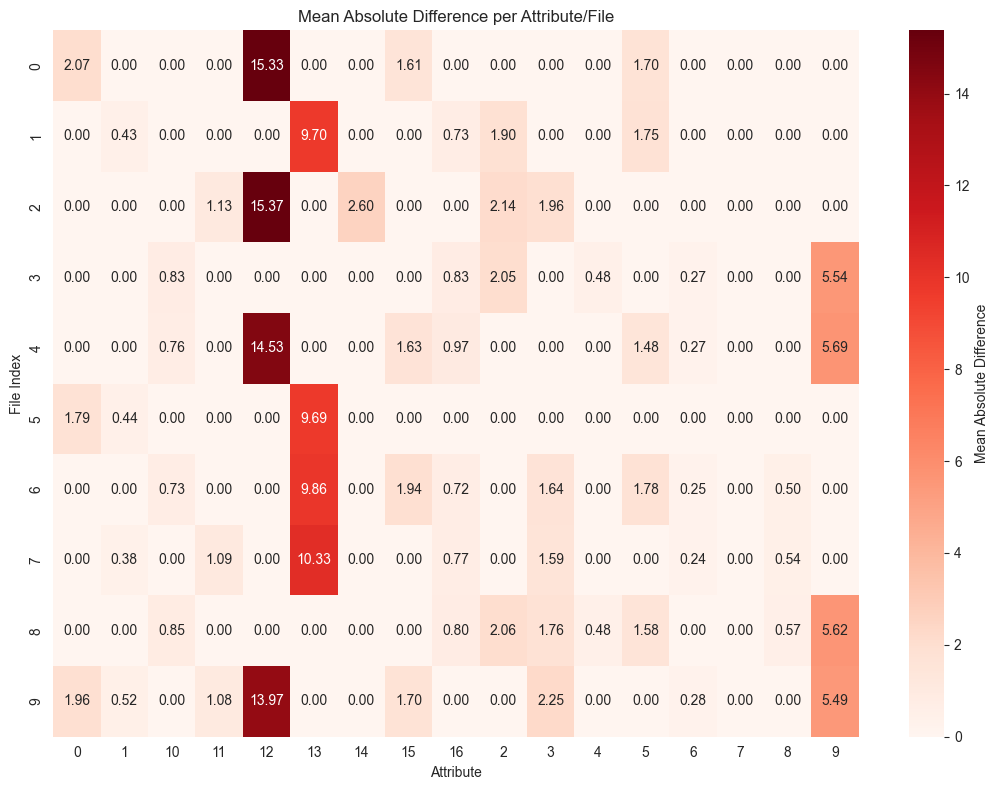

In [23]:
# Prepare a DataFrame to hold mean absolute differences
diff_matrix = pd.DataFrame(index=range(10), columns=all_attrs, dtype=float)

for file_idx in range(10):
    for attr in all_attrs:
        pure_vals = []
        fcm_vals = []

        num_rows = len(pureKNN_imputed[file_idx])
        for row_idx in range(num_rows):
            val1 = pureKNN_imputed[file_idx][row_idx].get(attr, np.nan)
            val2 = fcmKNN_imputed[file_idx][row_idx].get(attr, np.nan)

            if not (val1 != val1 or val2 != val2):  # check for NaN
                pure_vals.append(val1)
                fcm_vals.append(val2)

        if pure_vals and fcm_vals:
            diffs = np.abs(np.array(pure_vals) - np.array(fcm_vals))
            mean_diff = diffs.mean()
        else:
            mean_diff = np.nan

        diff_matrix.at[file_idx, attr] = mean_diff

plt.figure(figsize=(len(all_attrs)*0.4 + 4, 8))
sns.heatmap(diff_matrix, annot=True, fmt=".2f", cmap="Reds", cbar_kws={'label': 'Mean Absolute Difference'})

plt.title("Mean Absolute Difference per Attribute/File")
plt.xlabel("Attribute")
plt.ylabel("File Index")
plt.tight_layout()
plt.show()


# Test

In [24]:
iterations = [10, 50, 100, 1000]
nr_clusters = [50, 100, 250, 500, 1000]
durations = np.zeros((len(iterations), len(nr_clusters)))
mses = np.zeros((len(iterations), len(nr_clusters)))

for i, it in enumerate(iterations):
    for j, nc in enumerate(nr_clusters):

        print(f'Iterations: {it}, Nr of Clusters: {nc}')
        np_fd = [arr.copy() for arr in np_common_file_data]

        print('Running fuzzy c-means..')
        start = time.time()
        np_ccpf = calculate_fcm_clusters(np_fd, n_clusters=nc, maxiter=it)
        np_nb = run_knn(np_fd, column_masks, np_ccpf)
        im = impute(np_nb)
        duration = time.time() - start

        clean, f_clean, _, _ = get_statistics(pureKNN_imputed, im)
        _, mse, _, _ = mean_values(clean, f_clean)

        durations[i, j] = duration
        mses[i, j] = mse

Iterations: 10, Nr of Clusters: 50
Running fuzzy c-means..
Processing file 0 using C++ module...
Processing file 1 using C++ module...
Processing file 2 using C++ module...
Processing file 3 using C++ module...
Processing file 4 using C++ module...
Processing file 5 using C++ module...
Processing file 6 using C++ module...
Processing file 7 using C++ module...
Processing file 8 using C++ module...
Processing file 9 using C++ module...
C++ k-NN completed.
Iterations: 10, Nr of Clusters: 100
Running fuzzy c-means..
Processing file 0 using C++ module...
Processing file 1 using C++ module...
Processing file 2 using C++ module...
Processing file 3 using C++ module...
Processing file 4 using C++ module...
Processing file 5 using C++ module...
Processing file 6 using C++ module...
Processing file 7 using C++ module...
Processing file 8 using C++ module...
Processing file 9 using C++ module...
C++ k-NN completed.
Iterations: 10, Nr of Clusters: 250
Running fuzzy c-means..
Processing file 0 usi

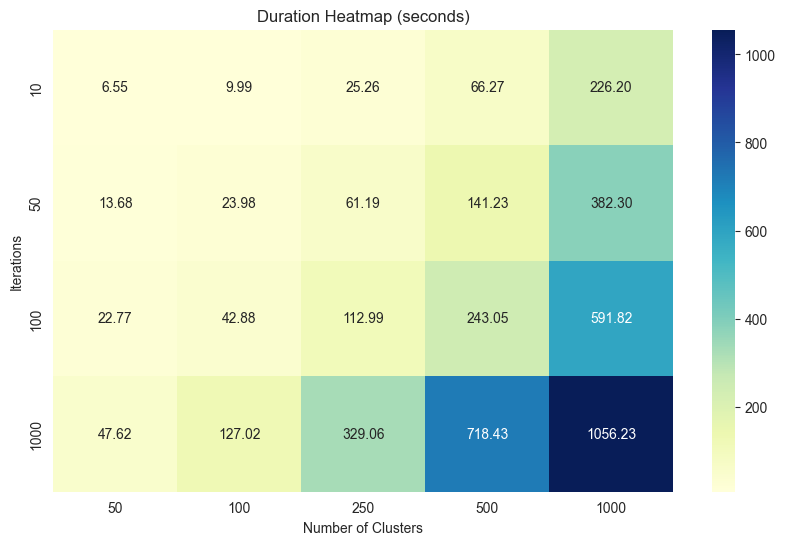

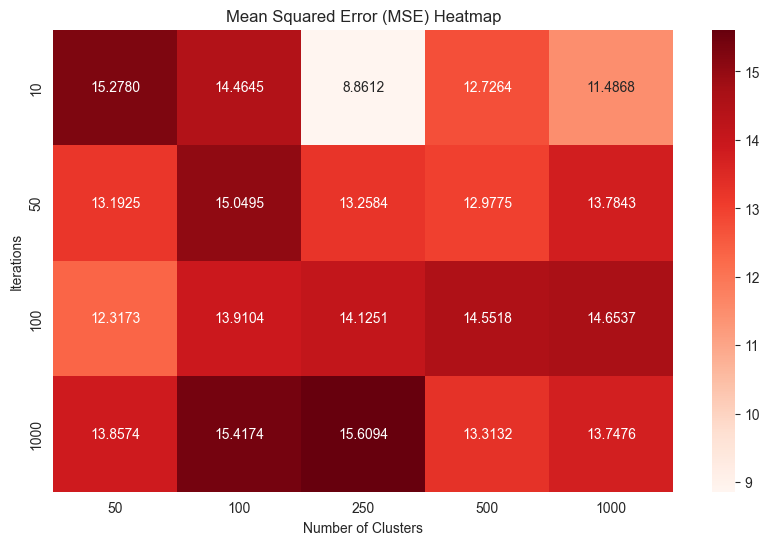

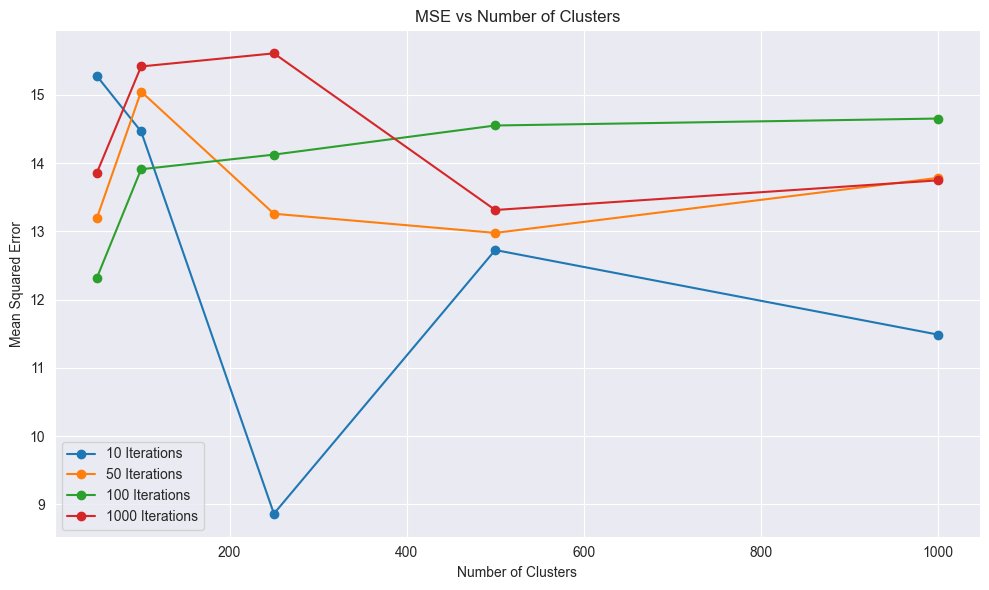

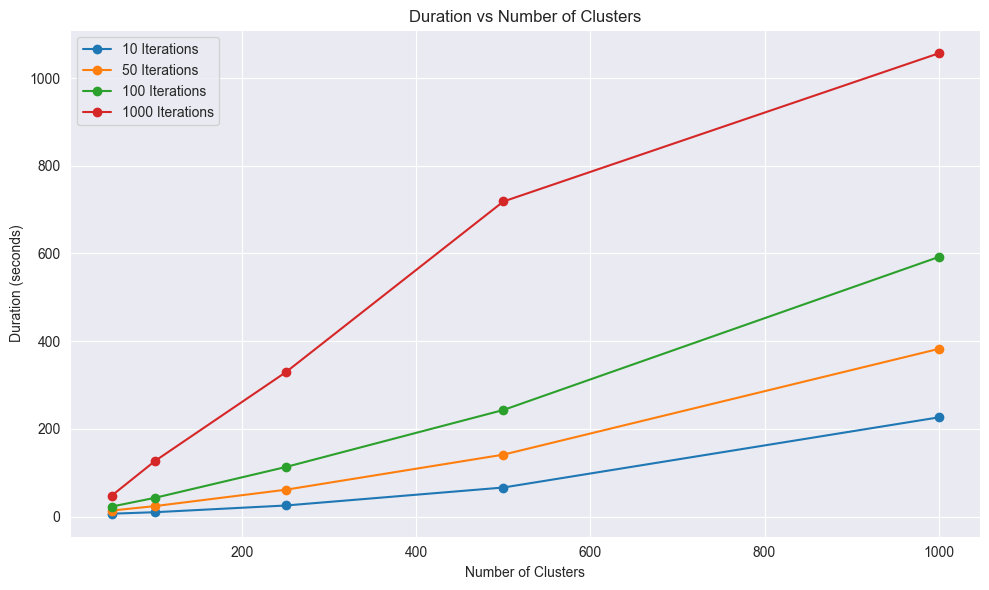

In [25]:
plot_results(iterations, nr_clusters, durations, mses)

- Wartości przy 10 iteracjach potrafią się bardzo wachać

## Detailed range 5-100 clusters

In [24]:
its_ = [80]
nr_cls_ = [5, 10, 50, 100, 200, 300, 400, 500]
drs_ = np.zeros((len(its_), len(nr_cls_)))
mses_ = np.zeros((len(its_), len(nr_cls_)))

for i, it in enumerate(its_):
    for j, nc in enumerate(nr_cls_):

        print(f'Iterations: {it}, Nr of Clusters: {nc}')
        np_fd = [arr.copy() for arr in np_common_file_data]

        print('Running fuzzy c-means..')
        start = time.time()
        np_ccpf = calculate_fcm_clusters(np_fd, n_clusters=nc, maxiter=it)
        np_nb = run_knn(np_fd, column_masks, np_ccpf)
        im = impute(np_nb)
        duration = time.time() - start

        clean, f_clean, _, _ = get_statistics(pureKNN_imputed, im)
        _, mse, _, _ = mean_values(clean, f_clean)

        drs_[i, j] = duration
        mses_[i, j] = mse

Iterations: 80, Nr of Clusters: 5
Running fuzzy c-means..
Processing file 0 using C++ module...
Processing file 1 using C++ module...
Processing file 2 using C++ module...
Processing file 3 using C++ module...
Processing file 4 using C++ module...
Processing file 5 using C++ module...
Processing file 6 using C++ module...
Processing file 7 using C++ module...
Processing file 8 using C++ module...
Processing file 9 using C++ module...
C++ k-NN completed.
Iterations: 80, Nr of Clusters: 10
Running fuzzy c-means..
Processing file 0 using C++ module...
Processing file 1 using C++ module...
Processing file 2 using C++ module...
Processing file 3 using C++ module...
Processing file 4 using C++ module...
Processing file 5 using C++ module...
Processing file 6 using C++ module...
Processing file 7 using C++ module...
Processing file 8 using C++ module...
Processing file 9 using C++ module...
C++ k-NN completed.
Iterations: 80, Nr of Clusters: 50
Running fuzzy c-means..
Processing file 0 using 

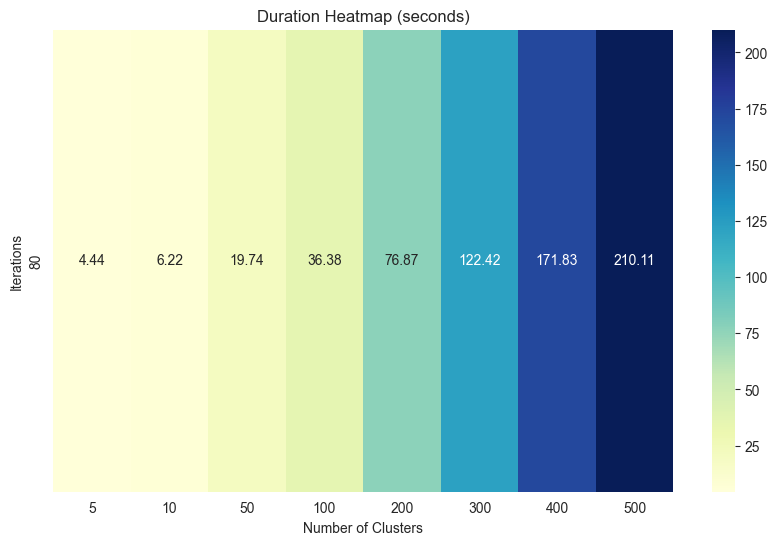

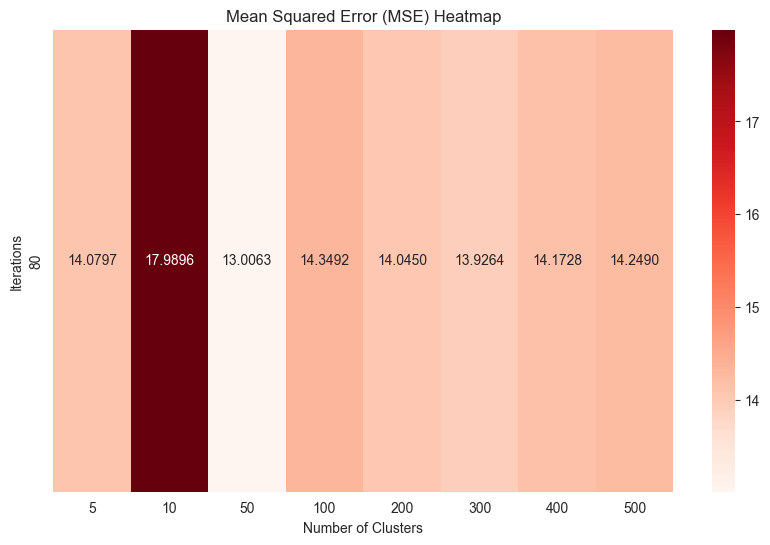

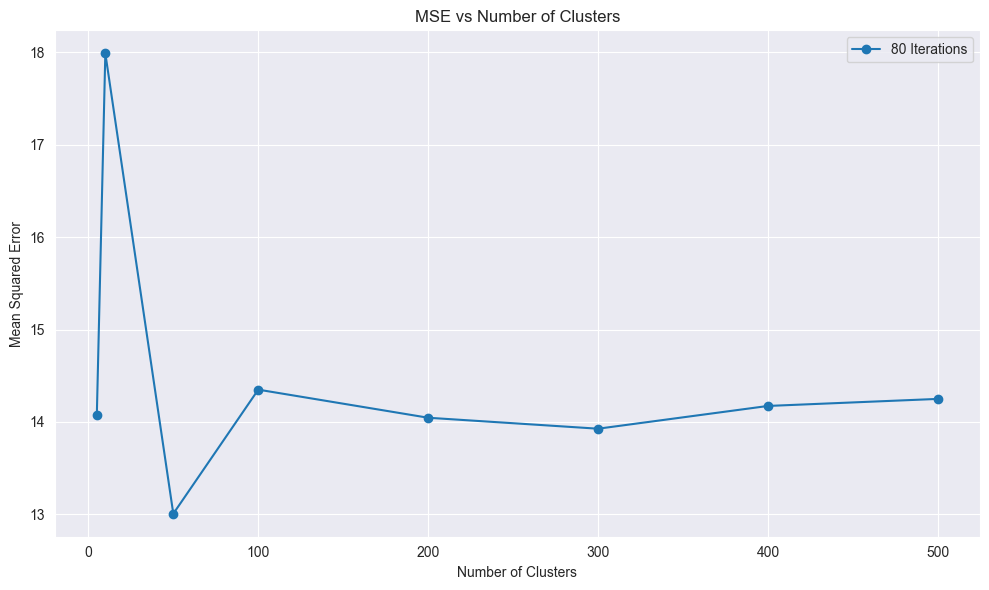

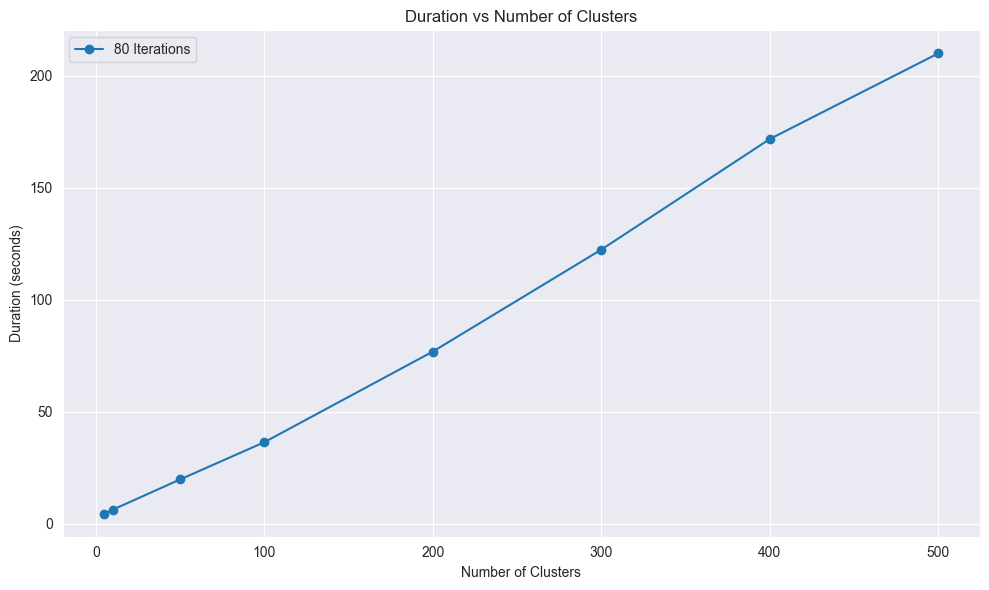

In [25]:
plot_results(its_, nr_cls_, drs_, mses_)

In [27]:
for i in range(len(nr_cls_)):
    print(f'{drs_[0][i]:.2f} seconds for {nr_cls_[i]} clusters')

4.44 seconds for 5 clusters
6.22 seconds for 10 clusters
19.74 seconds for 50 clusters
36.38 seconds for 100 clusters
76.87 seconds for 200 clusters
122.42 seconds for 300 clusters
171.83 seconds for 400 clusters
210.11 seconds for 500 clusters
